In [32]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [33]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [34]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [35]:
#with the probabilities we can get nost likely calss usging ps.topk
top_p, top_class = ps.topk(1, dim = 1)

#print the most likely classes for the first 10 examples
print(top_class[:10,:])


tensor([[1],
        [5],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])


In [36]:
#we can chack if the predicted classes match with the labels shape of the top_class is 2D (64, 1),
#while the labels is 1D with the shape (64). Therefore, we need to match the shape between top+class and labels
equals = top_class ==labels.view(*top_class.shape)

In [37]:
#now we need to calcualte the percentages of the predictions.
#for that we need to convert 'equals' to float tensor. if we use torch.mearn it returns a scalar tensor.
#to get the actual value as float we need to do 'accuracy.item()'
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f"Accuracy: {accuracy.item() * 100}%")


Accuracy: 12.5%


In [38]:
# Exercise: Implement the validation loop below. 
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

epochs = 30
steps = 0

train_losses, test_losses = [],[]
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        #turn off gradients for validation, saves memory and cimputation
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class ==labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
                train_losses.append(running_loss / len(trainloader))
                test_losses.append(test_loss / len(testloader))



In [39]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

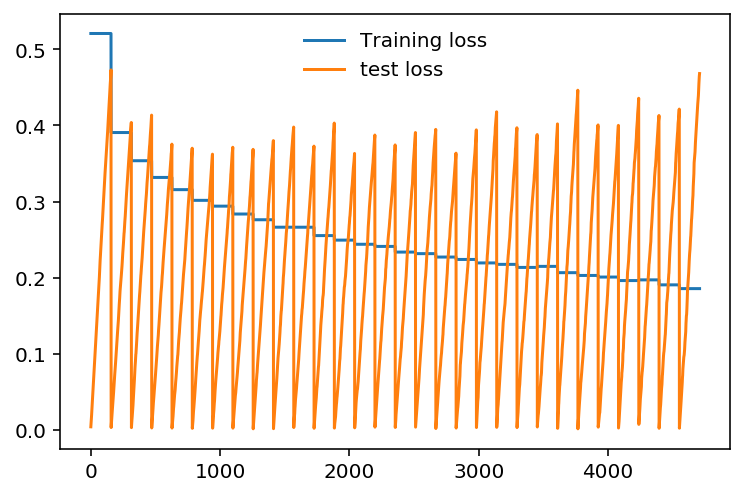

In [40]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "test loss")
plt.legend(frameon = False)

In [ ]:
#  Add dropout to your model and train it on Fashion-MNIST again.
# See if you can get a lower validation loss.

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        #Dropout module with 0.2 drop probabilities
        self.dropout = nn.Dropout(p = 0.2)
        
        def forward(self, x):
            x = x.view(x.shape[0], -1)
            
            #now with dropout
            x = self.dropout(F.relu(self.fc1(x)))
            x = self.dropout(F.relu(self.fc2(x)))
            x = self.dropout(F.relu(self.fc3(x)))
            
            #output so no dropout
            x = F.log_softmax(self.fc4(x), dim = 1)
            
            return x

In [41]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.515..  Test Loss: 0.434..  Test Accuracy: 0.850
Epoch: 2/30..  Training Loss: 0.393..  Test Loss: 0.417..  Test Accuracy: 0.851
Epoch: 3/30..  Training Loss: 0.355..  Test Loss: 0.390..  Test Accuracy: 0.861
Epoch: 4/30..  Training Loss: 0.336..  Test Loss: 0.385..  Test Accuracy: 0.862
Epoch: 5/30..  Training Loss: 0.321..  Test Loss: 0.374..  Test Accuracy: 0.865
Epoch: 6/30..  Training Loss: 0.304..  Test Loss: 0.363..  Test Accuracy: 0.873
Epoch: 7/30..  Training Loss: 0.293..  Test Loss: 0.368..  Test Accuracy: 0.869
Epoch: 8/30..  Training Loss: 0.287..  Test Loss: 0.351..  Test Accuracy: 0.878
Epoch: 9/30..  Training Loss: 0.274..  Test Loss: 0.382..  Test Accuracy: 0.870
Epoch: 10/30..  Training Loss: 0.265..  Test Loss: 0.387..  Test Accuracy: 0.871
Epoch: 11/30..  Training Loss: 0.258..  Test Loss: 0.368..  Test Accuracy: 0.875
Epoch: 12/30..  Training Loss: 0.256..  Test Loss: 0.383..  Test Accuracy: 0.874
Epoch: 13/30..  Training Loss: 0.247.

In [42]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

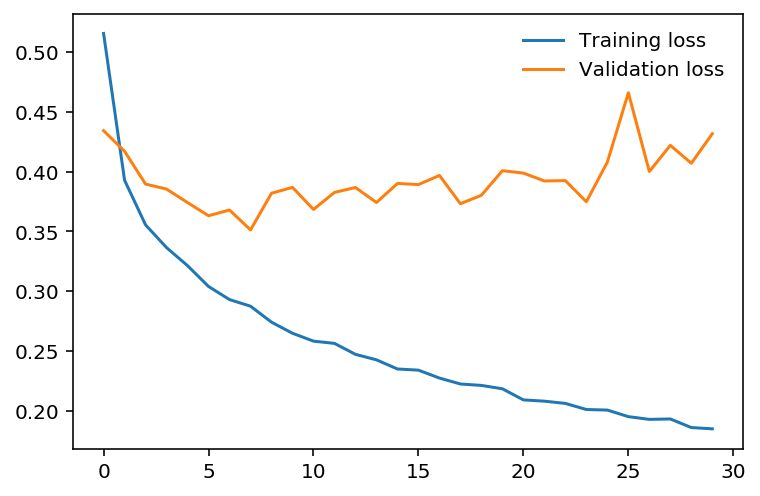

In [43]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(test_losses, label = 'Validation loss')
plt.legend(frameon = False)

In [44]:
# Exercise: Add dropout to your model and train it on Fashion-MNIST again. 
#See if you can get a lower validation loss.

In [45]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        #dropout module wirh 0.2 drop probabilitiy
        self.dropout = nn.Dropout(p = 0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        #with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        #output so no dropout
        x = F.log_softmax(self.fc4(x), dim = 1)
        
        return x

In [ ]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad(): #turn off the gradients
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train()
        
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(testloader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

In [48]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

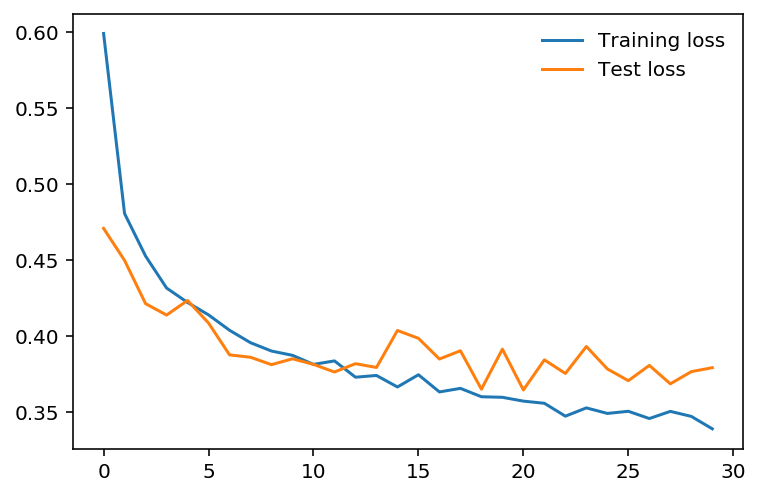

In [50]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(test_losses, label = 'Test loss')
plt.legend(frameon = False)

In [51]:
#Inference
import helper

#test on your network
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]

#convert 2D image into 1D vector
img = img.view(1, 784)

#calculate class probabilities for img
with torch.no_grad():
    output = model.forward(img)
    
ps = torch.exp(output)

#plot
helper,view_classify(imag.view(1, 28, 28), ps, version = 'Fashion')

NameError: name 'view_classify' is not defined